In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.widgets import Slider, Button
import scipy
import scipy.optimize
import scipy.io
from scipy.interpolate import interp1d
import nmrglue as ng
import pandas as pd
import pluq
#also requires openpyxl

from cops_analysis import cops_analyze

## COPS analysis importing the python file

In [4]:
%%time 
a = cops_analyze(['HNCA_nocop.ft3','HNCA_cop1.ft3','HNCA_cop3.ft3','HNCA_cop4.ft3','HNCA_cop5.ft3','HNCA_cop6.ft3'], mode='HNCA',pyruvate_on=True)

CPU times: user 3.39 ms, sys: 2.6 ms, total: 6 ms
Wall time: 15.2 ms


In [5]:
tb=pd.read_fwf('GB1_new.shifts', infer_nrows=300)
tb = tb.drop(index=[0,1,2,3,4,5])
tb = tb.rename(columns={'w1':'CA','w2':'N','w3':'HN'})

#realign spectra
tb = tb.set_index(tb['Assignment'])
tb = tb.drop(columns='Assignment')
shifts_array = tb.to_numpy(dtype=np.float32)
shifts_array[:,[0,1]]=shifts_array[:,[1,0]]

In [9]:
##clean my table: remove unused columns, remove rows for extraneous residues
##to do: fill in column dashes
#tb = pd.read_fwf('GB1.shifts')
#tb = tb.drop(columns=['?', 'Cb'])
#tb = tb.rename(columns={'Unnamed: 0':'residue'})
#tb = tb.set_index(tb['residue'])
#tb = tb.drop(columns=['residue'])
#tb = tb.drop(['T1', 'KA2','G8', 'T10','G13','T15', 'T16', 'T17', 'T24', 'X35', 'G37','G40', 'W42*','T43', 'T50', 'T48','T52','T54' ])
#tb = tb.drop(['KA2','W42*'])
#tb['Ca'] = tb['Ca'].astype('float')
#shifts_array = tb.to_numpy(dtype=np.float16)
#shifts_array = np.roll(shifts_array, 1, axis=1)

In [6]:
%%time
print(shifts_array[100])
a.CalcCB(shifts_array[100])

[131.501  54.056  10.246]
CPU times: user 266 ms, sys: 14.5 ms, total: 280 ms
Wall time: 282 ms


39.511426911424536

In [5]:
%%time
CBs = []
credence = []
pyr_fraction = []
for i in range(len(shifts_array)):
    try: 
        result = a.CalcCB(shifts_array[i], simple_output=False)
    except:
        result = ([0,0,0,0,0],[1])
    CBs = np.append(CBs, result[0][2])
    pyr_fraction = np.append(pyr_fraction, result[0][1])
    credence = np.append(credence, result[1])
tb['CB'] = CBs
tb['1/covariance'] = 1/credence

CPU times: user 38.6 s, sys: 2.71 s, total: 41.4 s
Wall time: 42.1 s


In [6]:
tb['pyruvate fraction'] = pyr_fraction

In [7]:
tb_truth = pd.read_excel('GB1_ground_truth_hw.xlsx')

In [8]:
tb['CB_scott'] = tb_truth['CB_scott'].to_numpy()
tb.to_excel('CB_fit_results.xlsx')

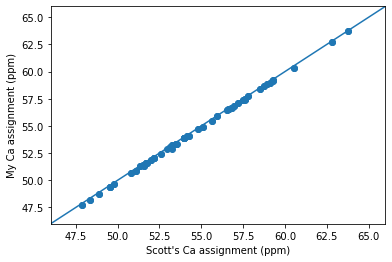

In [9]:
plt.scatter(tb_truth['CA'], tb['CA'])
plt.plot([46,66],[46,66])
plt.xlim([46,66])
plt.ylim([46,66])
plt.xlabel("Scott's Ca assignment (ppm)")
plt.ylabel("My Ca assignment (ppm)")
plt.show()


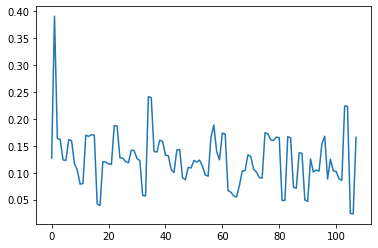

In [19]:
plt.plot(tb_truth['CA'].to_numpy()-tb['CA'].to_numpy())

## DEV

In [6]:
%%time
CBs = []
covariance = []
for i in range(len(shifts_array)):
    result = a.CalcCB_old(shifts_array[i])
    CBs = np.append(CBs, result[0])
    covariance = np.append(covariance, result[1])
tb['CB'] = CBs
tb['credence'] = covariance

ValueError: not enough values to unpack (expected 3, got 2)

(9.0, 46.0)

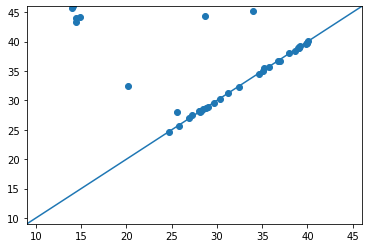

In [17]:
plt.scatter(tb_truth['CB_scott'], tb['CB']+0.125)
plt.plot([9,46],[9,46])
plt.xlim([9,46])
plt.ylim([9,46])

In [36]:
diagnose = shifts_array[10] #18 for K27, #-4 for K49
diagnose

array([126.2 ,  51.28,   8.54], dtype=float16)

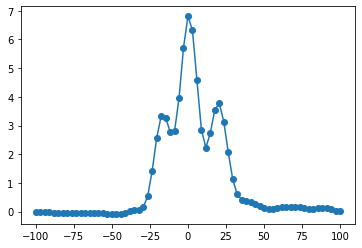

In [37]:
hz, nocop_trace = a.extract1D(diagnose, a.nocop_dat, a.nocop_unit_convs, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

[14.91710936  0.11069198 19.14977921 17.68207487  5.36744628]


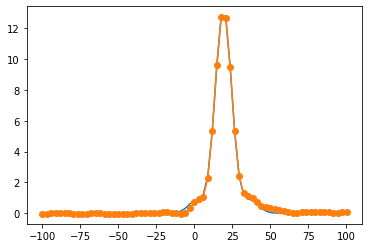

In [11]:
#later: implement rephasing of each lineshape

t = a.lineshape_fit(hz, nocop_trace, bounding=([0,0,-40,0,0],[50,1,60,40,10]))
print(t)
plt.plot(hz, a.lineshape(hz, *t), hz, nocop_trace, "-o")

#scale by integration

In [25]:
hz, line,_ = a.extract1D(diagnose, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)

17.60464118348849
5.704106561812847
0.2514627405025702
10.409894554374748
3.109933410468586
0.54290519136941


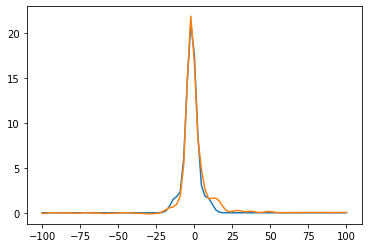

In [26]:
fit_tol = 10
print(t[3])
print(t[4])
print(t[1])
t1 = a.lineshape_fit(hz, line, bounding=([0,0,-10,t[3]-fit_tol,t[4]-fit_tol],[40,1,10,t[3]+fit_tol,t[4]+fit_tol]))
#t1 = a.lineshape_fit(hz, line, bounding=([0,0,-2,0,0],[1,1,2,40,10]))
plt.plot(hz, a.lineshape(hz, *t1), hz, line)
print(t1[3])
print(t1[4])
print(t1[1]/t[1])

17.60464118348849
5.704106561812847
15.539243607496799
2.7750871896842906
0.48850629333329154


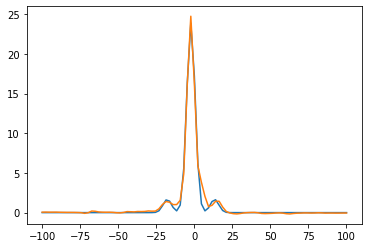

In [27]:
fit_tol = 10
print(t[3])
print(t[4])
hz, line,_ = a.extract1D(diagnose, a.cop_dats[0], a.cop_unit_convs[0], normalize=True)
t1 = a.lineshape_fit(hz, line, bounding=([0,0,-10,t[3]-fit_tol,t[4]-fit_tol],[40,1,10,t[3]+fit_tol,t[4]+fit_tol]))
#t1 = a.lineshape_fit(hz, line, bounding=([0,0,-2,0,0],[1,1,2,40,60]))
plt.plot(hz, a.lineshape(hz, *t1), hz, line)
print(t1[3])
print(t1[4])
print(t1[1]/t[1])

17.60464118348849
5.704106561812847
16.387447939800282
2.9102875703147464
0.9799510073198918


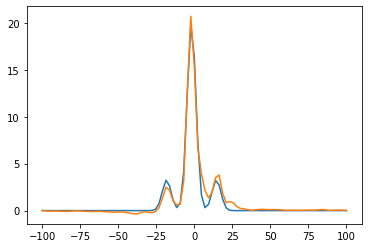

In [28]:
fit_tol = 10
print(t[3])
print(t[4])
hz, line,_ = a.extract1D(diagnose, a.cop_dats[2], a.cop_unit_convs[2], normalize=True)
t1 = a.lineshape_fit(hz, line, bounding=([0,0,-10,t[3]-fit_tol,t[4]-fit_tol],[40,1,10,t[3]+fit_tol,t[4]+fit_tol]))
#t1 = a.lineshape_fit(hz, line, bounding=([0,0,-2,0,0],[1,1,2,40,60]))
plt.plot(hz, a.lineshape(hz, *t1), hz, line)
print(t1[3])
print(t1[4])
print(t1[1]/t[1])

17.60464118348849
5.704106561812847
14.917398823388643
3.008940890999796
0.6888323641817807


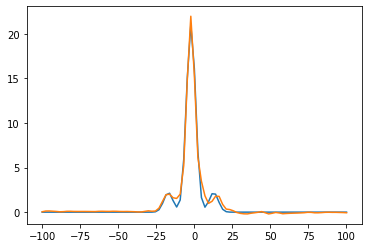

In [29]:
fit_tol = 10
n_cop = 3
print(t[3])
print(t[4])
hz, line,_ = a.extract1D(diagnose, a.cop_dats[n_cop], a.cop_unit_convs[n_cop], normalize=True)
t1 = a.lineshape_fit(hz, line, bounding=([0,0,-10,t[3]-fit_tol,t[4]-fit_tol],[40,1,10,t[3]+fit_tol,t[4]+fit_tol]))
#t1 = a.lineshape_fit(hz, line, bounding=([0,0,-2,0,0],[1,1,2,40,60]))
plt.plot(hz, a.lineshape(hz, *t1), hz, line)
print(t1[3])
print(t1[4])
print(t1[1]/t[1])

17.60464118348849
5.704106561812847
8.233592268292272
3.089803914715228
0.5559877106786003


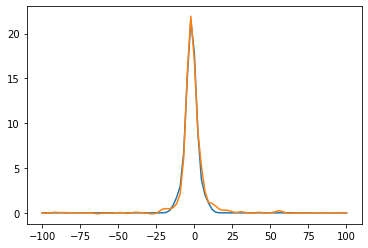

In [30]:
fit_tol = 10
n_cop = 4
print(t[3])
print(t[4])
hz, line,_ = a.extract1D(diagnose, a.cop_dats[n_cop], a.cop_unit_convs[n_cop], normalize=True)
t1 = a.lineshape_fit(hz, line, bounding=([0,0,-10,t[3]-fit_tol,t[4]-fit_tol],[40,1,10,t[3]+fit_tol,t[4]+fit_tol]))
#t1 = a.lineshape_fit(hz, line, bounding=([0,0,-2,0,0],[1,1,2,40,60]))
plt.plot(hz, a.lineshape(hz, *t1), hz, line)
print(t1[3])
print(t1[4])
print(t1[1]/t[1])

In [9]:
a = cops_analyze()


In [50]:
#strategy: fit for no COPs, then use fit parameters to constrain fits for COPs
hz, nocop_trace, normalizer = a.extract1D(diagnose, a.nocop_dat, a.nocop_unit_convs, normalize=True)
t = a.lineshape_fit(hz, nocop_trace)

#COP trace fitting bounded by determined fit parameters
fit_tol=2
bounds=([0,0,-2,t[3]-fit_tol,t[4]-fit_tol],[30,1,2,t[3]+fit_tol,t[4]+fit_tol])

frac = []
for i in range(len(a.cop_dats)):
    hz, line,_ = a.extract1D(diagnose, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)
    t1 = a.lineshape_fit(hz, line, bounding=bounds)
    frac = np.append(frac, t1[1])
    
frac_test = frac/t[1]
errors, pt = a.min_error_calc(frac_test)

AttributeError: 'cops_analyze' object has no attribute 'interp_points'

In [51]:
frac_test

array([0.90507059, 0.35542925, 0.26970034, 0.71149977, 0.92046323])

array([2.00000000e+00, 9.26482359e-23, 9.01120105e-01, 1.91649274e+01,
       1.00000000e+01])

In [52]:
plt.plot(np.linspace(a.cops[0][0], a.cops[0][-1],10000), 1/errors)
print(pt)

NameError: name 'errors' is not defined

In [ ]:
#what if you multiply with a Cb prior probability?

In [28]:
###reads in Cb and the set of lineshape parameters to output an array of predicted lineshapes for (index 0) nocop and each cop (index 1-5)
def lineshape_Cb(w, k_abs, pyr_fraction, Cb, c, j, lwid):
    recoupling_fractions = [(1+a.dec_interpolation[i](Cb))/2 for i in range(5)]
    lineshapes = np.array([a.lineshape(w, k_abs, pyr_fraction*recoupling_fractions[i], c, j, lwid) for i in range(5)])
    lineshapes=lineshapes.reshape(-1)
    return lineshapes

#####
#MAIN FUNCTION. takes in data point coordinates in ppm, and outputs the triangulated Cb, directly optimized over lineshapes. 
#####
def CalcCB(data_pt, fit_tol=10):
    #strategy: optimize Cb coupling fraction in parallel to extract Cb directly
    hz, nocop_trace = a.extract1D(data_pt, a.nocop_dat, a.nocop_unit_convs, C_offset=-0.09, normalize=True)
    nocop_params = a.lineshape_fit(hz, nocop_trace)
    #unpack some fit parameters
    pyr_fraction = nocop_params[1]
    print(pyr_fraction)
    j_ab = nocop_params[3]
    lwid=nocop_params[4]

    hz = a.extract1D(data_pt, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)[0]
    cop_1Ds = np.array([a.extract1D(data_pt, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)[1] for i in range(5)])
    cop_1Ds = cop_1Ds.reshape(-1)

    '''bounding: [k_abs, pyr_fraction, Cb, c, j, lwid]'''

    for i in range(7):

        #initializes CB to a ppm value between 10 and 45, inclusive. 
        prior_cb = 15+i*5
        #initialize prior and bounds of fitting.
        if a.pyr_on:
            p = [15,pyr_fraction,prior_cb,0,j_ab,lwid]
            bounds = ([0,pyr_fraction-fit_tol/200,9,-5,j_ab-fit_tol/4,lwid-fit_tol/4],[40,pyr_fraction+fit_tol/200,46,5,j_ab+fit_tol/4,lwid+fit_tol/4])
            params = a.lineshape_Cb_fit(hz, cop_1Ds, prior=p, bounding=bounds)
        else:
            p = [15,1,prior_cb,0,j_ab,lwid]
            bounds = ([0,0.999,9,-30,j_ab-20,lwid-5],[40,1,46,30,j_ab+20,lwid+5])
            params = a.lineshape_Cb_fit(hz, cop_1Ds, prior=p, bounding=bounds)


        #measures the squared error between experimental and simulated peak profile
        sq_error = np.sum((a.lineshape_Cb(hz, *params)-cop_1Ds)**2)

        #determines which of the initial CB values produces the smallest error.  
        if i ==0:
            min_sq = sq_error
            best_params = params
        if sq_error<min_sq:
            best_params = params
            min_sq = sq_error
            
            
    return best_params, 1/min_sq#returns Cb, and variance of the Cb estimation

def lineshape_Cb_fit(x, y, prior, bounding=([0,0,9,-5,0,0],[20,1,46,5,40,10])):
    param_best, param_covariance = scipy.optimize.curve_fit(lineshape_Cb, x, y, p0 = prior, bounds=bounding)
    return param_best, param_covariance

In [44]:
data = shifts_array[40]
params,_ = CalcCB(data)
print([(1+a.dec_interpolation[i](params[2]))/2 for i in range(5)])
print(params)
print(params[2])

0.43317909336335403
[0.9757565759422544, 0.2887498186232503, 0.22416928506996742, 0.7135664217275345, 0.975398282990156]
[23.19200046  0.40108573 38.85053932 -2.43517308 17.31075025  3.13040381]
38.850539317765374


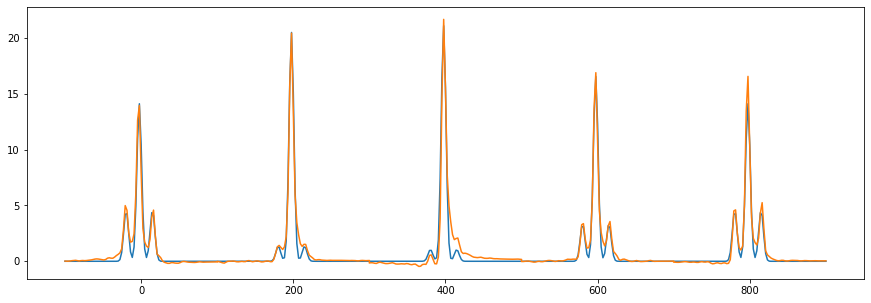

In [45]:
hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)[1] for i in range(5)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(5)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, lineshape_Cb(hz, *params), hz_long, cop_1Ds)

## prepare class

In [7]:
#import data
nocop_dic, nocop_dat = ng.pipe.read_lowmem_3D('HNCA_nocop.ft3')

# make unit conversion objects for each axis of each spectrum
nocop_unit_convs = [ng.pipe.make_uc(nocop_dic, nocop_dat, i) for i in range(3)]   #i=0: N, #i=1: CA, #i=2: H

In [8]:
nocop_dat.shape

(256, 2048, 313)

In [9]:
##array of 5 dictionaries, 1 per COP spectrum
cop_dics = np.array([ng.pipe.read_lowmem_3D('HNCA_cop%i.ft3' %(i+1))[0] for i in range(5)]) 
##array of 5 datasets, 1 per COP spectrum
cop_dats = [ng.pipe.read_lowmem_3D('HNCA_cop%i.ft3' %(i+1))[1] for i in range(5)] ##shape: [number of COPs, w1 (15N), w2 (13C), w3 (1H)]
len(cop_dats)

##5 by 3 array, 1 unit converter per dimension per COP spectrum
cops_unit_convs = np.array([[ng.pipe.make_uc(cop_dics[j], cop_dats[j], i) for i in range(3)] for j in range(5)]) ##shape: [number of COPs, 3]
cops_unit_convs.shape

(5, 3)

In [10]:
datapt = [121.3, 52.42, 7.854]

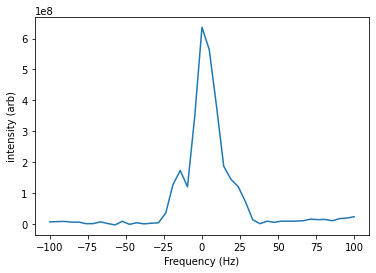

CPU times: user 101 ms, sys: 16.8 ms, total: 117 ms
Wall time: 47.2 ms


In [21]:
%%time
def hz_to_idx(uconv, Hz):
    return uconv(0, "Hz")-uconv(Hz, "Hz")

#given a spectrum and unit conversion triple, extract 1D trace from center of peak at data_pt_ppm. tw: trace width, Hertz. 
def extract1D(data_pt_ppm, spectrum, uc, sw=100, normalize=False):

    #convert data_pt_ppm to index
    idx = np.array([uc[0](data_pt_ppm[0], "ppm"), uc[1](data_pt_ppm[1], "ppm"), uc[2](data_pt_ppm[2], "ppm")])

    #calculate indices for trace boundary, based on tw. 
    hz_bounds = hz_to_idx(uc[1], sw)
    hz_vals = np.linspace(-hz_bounds, hz_bounds, num=2*hz_bounds+1)*sw/hz_bounds

    #1D slice through peak center, added to 1D slices through nearby HN, N points by tensor product
    weights = np.array([[0.6, 0.8, 1, 0.8, 0.6]]) #weights vector to compute weighted sum
    #trace = spectrum[idx[0], idx[1]-hz_bounds:idx[1]+hz_bounds+1,idx[2]]
    trace = np.tensordot(spectrum[idx[0]-2:idx[0]+3, idx[1]-hz_bounds:idx[1]+hz_bounds+1,idx[2]-2:idx[2]+3],weights.T@weights, axes=([0,2],[0,1]))

    if normalize:
        #normalize
        normalizer=np.max(trace)
        trace=trace/normalizer
        return hz_vals, trace, normalizer
    return hz_vals, np.array(trace)

plt.plot(*extract1D(datapt, cop_dats[1], cops_unit_convs[1]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("intensity (arb)")
plt.show()

## COPS simulated profiles

In [2]:
mat = scipy.io.loadmat('dec_profiles_named.mat')

In [3]:
#cops[0]: frequency axis. cops[1]-[5]: decoupling profiles for gradcop 1, 3, 4, 5, 6. 
cops = mat.get('dec_profiles')[0:6]

#trim cops to remove CO decoupling profile
cops=cops[:,:171]

def cop_frac(Cbeta, copnum=1):
    a = interp1d(cops[0], cops[copnum], kind='cubic')
    return 1/2*(1+a(Cbeta))
    

In [4]:
cop_frac(37)

0.9101494658349704

## Generate synthetic lineshapes

In [3]:
def lineshape_inter_plot():
    w = np.linspace(-100, 100, 200)
    fraction_init = 0.35
    k_abs_init = 10
    c_init = 0
    j_init = 30
    lw_init=7
    Cb_init=30
    

    fig, ax = plt.subplots()
    line1, = plt.plot(w, lineshape(w, k_abs_init, fraction_init*cop_frac(Cb_init), c_init, j_init,lw_init), lw=2, label='grad1')
    line2, = plt.plot(w, lineshape(w, k_abs_init, fraction_init*cop_frac(Cb_init, copnum=2), c_init, j_init,lw_init), lw=2, label='grad3')
    line3, = plt.plot(w, lineshape(w, k_abs_init, fraction_init*cop_frac(Cb_init, copnum=3), c_init, j_init,lw_init), lw=2, label='grad4')
    line4, = plt.plot(w, lineshape(w, k_abs_init, fraction_init*cop_frac(Cb_init, copnum=4), c_init, j_init,lw_init), lw=2, label='grad5')
    line5, = plt.plot(w, lineshape(w, k_abs_init, fraction_init*cop_frac(Cb_init, copnum=5), c_init, j_init,lw_init), lw=2, label='grad6')
    ax.set_xlabel('frequency (Hz)')
    plt.subplots_adjust(bottom=0.3)
    plt.xlim([-100,100])
    plt.ylim([0, 15])
    plt.legend()

    ax1 = plt.axes([0.2, 0.17, 0.65, 0.03])
    fraction_slider = Slider(
        ax=ax1,
        label='doublet fraction',
        valmin=0,
        valmax=1,
        valinit=fraction_init,
    )


    ax2 = plt.axes([0.2, 0.13, 0.65, 0.03])
    j_slider = Slider(
        ax=ax2,
        label="$J_{ab}$ (Hz)",
        valmin=0,
        valmax=50,
        valinit=j_init,
    )

    ax3 = plt.axes([0.2, 0.09, 0.65, 0.03])
    lw_slider = Slider(
        ax=ax3,
        label="linewidth (Hz)",
        valmin=0,
        valmax=50,
        valinit=lw_init,
    )

    
    ax4 = plt.axes([0.2, 0.05, 0.65, 0.03])
    Cb_slider = Slider(
        ax=ax4,
        label="Cb (ppm)",
        valmin=9,
        valmax=46,
        valinit=Cb_init,
    )



    # The function to be called anytime a slider's value changes
    def update(val):
        line1.set_ydata(lineshape(w, k_abs_init, fraction_slider.val*cop_frac(Cb_slider.val, copnum=1), c_init, j_slider.val,lw_slider.val))
        line2.set_ydata(lineshape(w, k_abs_init, fraction_slider.val*cop_frac(Cb_slider.val, copnum=2), c_init, j_slider.val,lw_slider.val))
        line3.set_ydata(lineshape(w, k_abs_init, fraction_slider.val*cop_frac(Cb_slider.val, copnum=3), c_init, j_slider.val,lw_slider.val))
        line4.set_ydata(lineshape(w, k_abs_init, fraction_slider.val*cop_frac(Cb_slider.val, copnum=4), c_init, j_slider.val,lw_slider.val))
        line5.set_ydata(lineshape(w, k_abs_init, fraction_slider.val*cop_frac(Cb_slider.val, copnum=5), c_init, j_slider.val,lw_slider.val))
        fig.canvas.draw_idle()


    # register the update function with each slider
    fraction_slider.on_changed(update)
    j_slider.on_changed(update)
    lw_slider.on_changed(update)
    Cb_slider.on_changed(update)

    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = plt.axes([0.8, 0.21, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')


    def reset(event):
        fraction_slider.reset()
        j_slider.reset()
        lw_slider.reset()
    button.on_clicked(reset)

    plt.show()
    return None

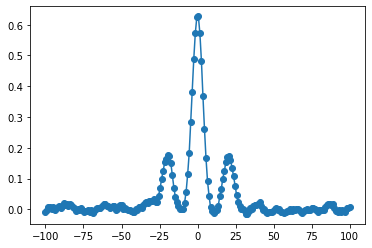

In [11]:
%matplotlib inline
def lineshape_gen(snr=30, sampling = 150):
    noisewindow = 8
    k_abs_init = 1
    noise_level = k_abs_init/snr
    noise=np.convolve(np.random.normal(0,noise_level,sampling+noisewindow-1), np.ones(noisewindow)/noisewindow, mode='valid')
    
    w = np.linspace(-100, 100, sampling)
    fraction_init = 0.35

    c_init = 0
    j_init = 20
    lw_init=7
    return lineshape(w, k_abs_init, fraction_init, c_init, j_init, lw_init)+noise

samples=200
test_ls = lineshape_gen(sampling=samples)
omega = np.linspace(-100, 100, samples)
plt.plot(omega, test_ls, 'o-')

## Fit experimental lineshapes

[ 1.00678168  0.34812893  0.10448026 19.25600468  6.92996425]


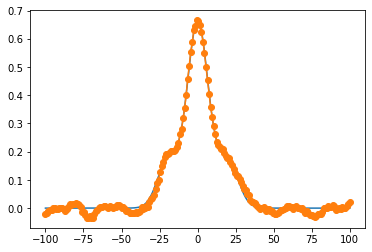

In [7]:
#bounds: [k_abs, fraction, c, j, lwid]:
bounding=([0,0,-2,0,0],[2,1,2,50,50])

a, _=scipy.optimize.curve_fit(lineshape, omega, test_ls,p0=[1, 0.33, 1, 40, 20], bounds=([0,0,-100,0,0],[20,1,100,50,50]))

print(a)
plt.plot(omega, lineshape(omega,*a), '-')
plt.plot(omega, test_ls, 'o-')

In [39]:
#[0.1 (GNG), 0.35 (TCA), 0.5 (ILV)]

## Triangulate Cb

In [11]:
def lineshape(w, k_abs, fraction, c, j, lwid):
    return k_abs/2*fraction*np.exp(-(w-c-j)**2/(lwid**2/2))+k_abs*(1-fraction)*np.exp(-(w-c)**2/(lwid**2/2))+k_abs/2*fraction*np.exp(-(w-c+j)**2/(lwid**2/2))

In [15]:
## procedure: 1. extract 1D slices from each gradcop and the normal HNCA. 
## 2. fit the peaks, obtaining percent peak heights. normalize the peak height against the unGRADCOPped sample.   
## 3. use percent peak height for each COP to triangulate. 

##vectorized calculation of error for each Cb point, starting from peak fractions. could also do this by a different optimization method. 
def min_error_calc(fracs_vector, cops_matrix, interp_points=2000):
    a = [interp1d(cops_matrix[0], cops_matrix[i+1], kind='cubic') for i in range(5)]
    
    error=np.array([])
    freqs = np.linspace(cops_matrix[0][0], cops_matrix[0][-1],interp_points)
    
    predict1=(1+a[0](freqs))/2
    predict2=(1+a[1](freqs))/2
    predict3=(1+a[2](freqs))/2
    predict4=(1+a[3](freqs))/2
    predict5=(1+a[4](freqs))/2
    predicts=np.stack((predict1, predict2, predict3, predict4, predict5))
    
    fracs_vectors = np.reshape(fracs_vector,[-1,1])@np.reshape(np.ones(interp_points),[1,-1])
    errors = np.sum((predicts-fracs_vectors)**2,axis=0)
    
    return errors, freqs[np.argmin(errors)]
        
    
    

24.97079707970797


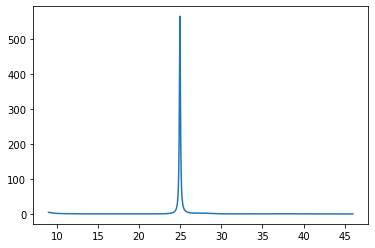

In [16]:
fracs_test = np.array([cop_frac(25, copnum=i+1)+np.random.normal(0,0.03) for i in range(5)])

errors, pt = min_error_calc(fracs_test, cops, interp_points=10000)
plt.plot(np.linspace(cops[0][0], cops[0][-1],10000), 1/errors)
print(pt)